# TESTING MODELS

Let us try a few classification models
## Classical ML models

In [36]:
import pandas as pd
import time
import numpy as np
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, multilabel_confusion_matrix, accuracy_score, classification_report, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
models = []

In [38]:
df = pd.read_csv('data/cleaned_train.csv')
feats = []
with open('data/features.txt','r') as f:
    feats = [x[:-1] for x in f.readlines()]
df.shape, df.columns, feats

((75018, 53),
 Index(['id', 'marital_status', 'appln_mode', 'appln_order', 'prog_of_study',
        'morn/eve_attend', 'prev_edu', 'prev_edu_grade', 'nationality',
        'mom_edu', 'dad_edu', 'mom_occup', 'admission_grade', 'was_displaced',
        'edu_spl_need', 'has_student_debt', 'no_fee_dues', 'gender',
        'got_scholarship', 'age_at_start', 'sem1_units_credited',
        'sem1_units_enrolled', 'sem1_units_eval', 'sem1_units_approved',
        'sem1_units_grade', 'sem1_units_no_eval', 'sem2_units_credited',
        'sem2_units_enrolled', 'sem2_units_eval', 'sem2_units_approved',
        'sem2_units_grade', 'sem2_units_no_eval', 'unemployment_rate',
        'inflation', 'gdp', 'Target', 'marital_status_log', 'appln_order_log',
        'prog_of_study_log', 'morn/eve_attend_log', 'prev_edu_log',
        'mom_occup_log', 'edu_spl_need_log', 'has_student_debt_log',
        'no_fee_dues_log', 'got_scholarship_log', 'age_at_start_log',
        'sem1_units_credited_log', 'sem1_units

We use only the selected features

In [39]:
X,y = df.drop(columns=['Target','id','nationality']).values, df['Target'].values

(Target
 Graduate    36603
 Dropout     23669
 Enrolled    14746
 Name: count, dtype: int64,
 <Axes: >)

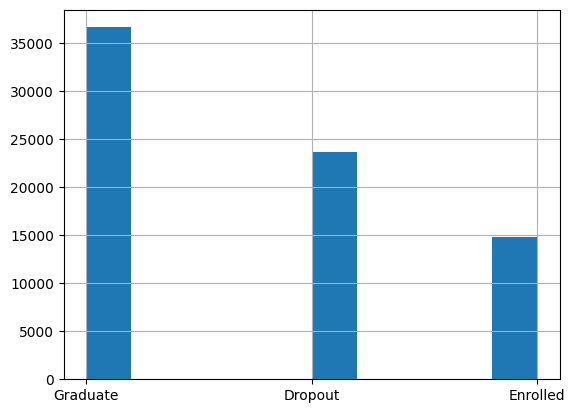

In [40]:
df['Target'].value_counts(), df['Target'].hist()

So we have an imbalanced dataset. To handle this - for classical ML models, we oversample the smaller classes

In [41]:
# Train test split
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y_l = le.fit(y)
y_enc = y_l.transform(y)

X_train, X_val, y_train, y_val = train_test_split(X, y_enc, test_size=0.2, random_state=42)

### Decision tree

First we check the performance without any oversampling

In [42]:
from sklearn import tree

In [43]:
%%time
model_dt = tree.DecisionTreeClassifier()
start = time.perf_counter()
model_dt.fit(X_train,y_train)
end = time.perf_counter()

CPU times: total: 656 ms
Wall time: 982 ms


In [44]:
y_pred = model_dt.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[ 9360,   945],
        [  800,  3899]],

       [[10552,  1491],
        [ 1449,  1512]],

       [[ 6492,  1168],
        [ 1355,  5989]]], dtype=int64)

In [45]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7186283171424129, 0.7597973873633698)

In [46]:
print('DECISION TREE - NO PREPROCESSING')
x = classification_report(y_val, y_pred, labels = sorted(list(set(y_enc))), digits=4, output_dict=True)
models.append({'model':'Decision_tree_no_preprocessing', 'metrics': x, 'training_time(s)':(end-start)})
pd.DataFrame(models)

DECISION TREE - NO PREPROCESSING


,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8049132947976878, 'recal...",0.980486


Next, let us use `SMOTE` (Synthetic Minority Over-sampling Technique) to oversample the minority classes

In [47]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [48]:
#Apply Over Sampling
print(f'Before Oversampling {sorted(Counter(y_train).items())}')
X_train1, y_train1 = SMOTE().fit_resample(X_train, y_train)
print(f'After Oversampling {sorted(Counter(y_train1).items())}')

Before Oversampling [(0, 18970), (1, 11785), (2, 29259)]
After Oversampling [(0, 29259), (1, 29259), (2, 29259)]


In [49]:
%%time
model_dt = tree.DecisionTreeClassifier()
start = time.perf_counter()
model_dt.fit(X_train1,y_train1)
end = time.perf_counter()

CPU times: total: 2.5 s
Wall time: 3.41 s


In [50]:
y_pred = model_dt.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[ 9408,   897],
        [  810,  3889]],

       [[10515,  1528],
        [ 1378,  1583]],

       [[ 6518,  1142],
        [ 1379,  5965]]], dtype=int64)

In [51]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7248224169624033, 0.7622633964276193)

In [52]:
print('DECISION TREE - SMOTE')
x = classification_report(y_val, y_pred, labels = sorted(list(set(y_enc))), digits=4, output_dict=True)
models.append({'model':'Decision_tree_oversampling', 'metrics': x, 'training_time(s)':(end-start)})
pd.DataFrame(models)

DECISION TREE - SMOTE


,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8049132947976878, 'recal...",0.980486
1,Decision_tree_oversampling,"{'0': {'precision': 0.8125783535311325, 'recal...",3.405618


Let us try an undersampler

In [53]:
from imblearn.under_sampling import RandomUnderSampler

In [54]:
#Apply Random Under Sampling
rus = RandomUnderSampler(random_state=0)
print(f'Before Undersampling {sorted(Counter(y_train).items())}')
X_train1, y_train1 =rus.fit_resample(X_train, y_train)
print(f'After Undersampling {sorted(Counter(y_train1).items())}')

Before Undersampling [(0, 18970), (1, 11785), (2, 29259)]
After Undersampling [(0, 11785), (1, 11785), (2, 11785)]


In [55]:
%%time
model_dt = tree.DecisionTreeClassifier()
start = time.perf_counter()
model_dt.fit(X_train1,y_train1)
end = time.perf_counter()

CPU times: total: 188 ms
Wall time: 766 ms


In [56]:
y_pred = model_dt.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[9429,  876],
        [ 834, 3865]],

       [[9828, 2215],
        [1061, 1900]],

       [[6817,  843],
        [2039, 5305]]], dtype=int64)

In [57]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7288496421248073, 0.7378032524660091)

In [58]:
print('DECISION TREE - Random Undersampler')
x = classification_report(y_val, y_pred, labels = sorted(list(set(y_enc))), digits=4, output_dict=True)
models.append({'model':'Decision_tree_undersampling', 'metrics': x, 'training_time(s)':(end-start)})
pd.DataFrame(models)

DECISION TREE - Random Undersampler


,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8049132947976878, 'recal...",0.980486
1,Decision_tree_oversampling,"{'0': {'precision': 0.8125783535311325, 'recal...",3.405618
2,Decision_tree_undersampling,"{'0': {'precision': 0.8152288546720101, 'recal...",0.765867


So, the performance is not vastly affected by the oversampling or undersampling => Decision tree is robust to imbalanced data

### Random Forest

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
estims = [5,10,20,50,100,200,300]
model = RandomForestClassifier()
acc,tim = [], []
for x in estims:
    model = RandomForestClassifier(n_estimators=x,warm_start=True)
    start = time.perf_counter()
    model.fit(X_train,y_train)
    end = time.perf_counter()
    y_pred = model.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_estimators: {x}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_estimators: 5, time_taken: 0.9854593998752534s, accuracy: 0.8025193281791523
n_estimators: 10, time_taken: 1.267887500114739s, accuracy: 0.8160490535857104
n_estimators: 20, time_taken: 2.758644700050354s, accuracy: 0.8297120767795254
n_estimators: 50, time_taken: 8.566147099947557s, accuracy: 0.8329778725673154
n_estimators: 100, time_taken: 20.64796460000798s, accuracy: 0.8375766462276726
n_estimators: 200, time_taken: 49.65825400012545s, accuracy: 0.8364436150359904
n_estimators: 300, time_taken: 76.8785306001082s, accuracy: 0.835110637163423


Pick best model

In [61]:
model1 = RandomForestClassifier(n_estimators=estims[np.argmax(acc)],warm_start=True)
start = time.perf_counter()
model1.fit(X_train,y_train)
end = time.perf_counter()
y_pred = model1.predict(X_val)
_acc = accuracy_score(y_val,y_pred)
print(f'n_estimators: {x}, time_taken: {end-start}s, accuracy: {_acc}')

n_estimators: 300, time_taken: 26.715764000080526s, accuracy: 0.8339776059717409


In [62]:
model.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(n_estimators=300, warm_start=True)>

In [63]:
y_pred = model.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'RandomForest_no_preprocessing', 'metrics': x, 'training_time(s)': tim[-1]})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8049132947976878, 'recal...",0.980486
1,Decision_tree_oversampling,"{'0': {'precision': 0.8125783535311325, 'recal...",3.405618
2,Decision_tree_undersampling,"{'0': {'precision': 0.8152288546720101, 'recal...",0.765867
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9437790271327304, 'recal...",76.878531


Text(0.5, 1.0, 'Training time')

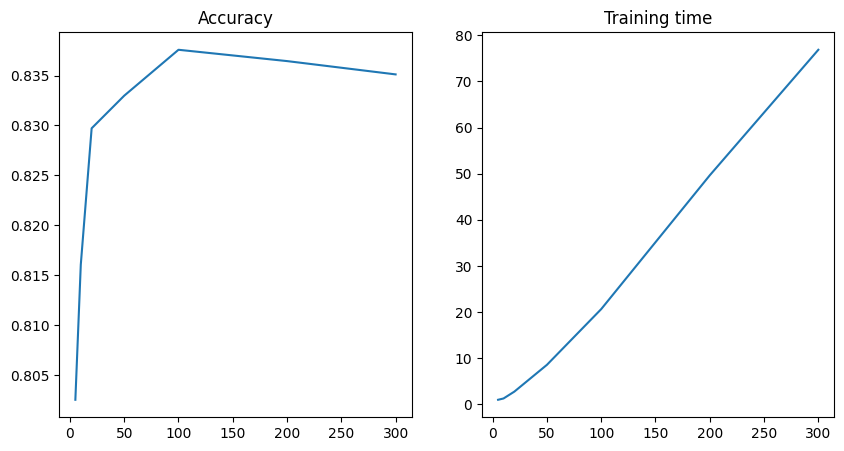

In [64]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(estims,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(estims,tim)
ax2.set_title('Training time')

Try with SMOTE

In [65]:
X_train1, y_train1 = SMOTE().fit_resample(X_train,y_train)
estims = [5,10,20,50,100,200,300]
model = RandomForestClassifier()
acc,tim = [], []
for x in estims:
    model = RandomForestClassifier(n_estimators=x,warm_start=True)
    start = time.perf_counter()
    model.fit(X_train1,y_train1)
    end = time.perf_counter()
    y_pred = model.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_estimators: {x}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_estimators: 5, time_taken: 3.3944650997873396s, accuracy: 0.7979872034124234
n_estimators: 10, time_taken: 7.2505385999102145s, accuracy: 0.8142495334577446
n_estimators: 20, time_taken: 14.392014099983498s, accuracy: 0.825246600906425
n_estimators: 50, time_taken: 37.405577400000766s, accuracy: 0.832178085843775
n_estimators: 100, time_taken: 78.1692329000216s, accuracy: 0.8335777126099707
n_estimators: 200, time_taken: 146.6786739998497s, accuracy: 0.8348440415889096
n_estimators: 300, time_taken: 214.04704680014402s, accuracy: 0.8354438816315649


Pick best model

In [66]:
model1 = RandomForestClassifier(n_estimators=estims[np.argmax(acc)],warm_start=True)
start = time.perf_counter()
model1.fit(X_train1,y_train1)
end = time.perf_counter()
y_pred = model1.predict(X_val)
_acc = accuracy_score(y_val,y_pred)
print(f'n_estimators: {estims[np.argmax(acc)]}, time_taken: {end-start}s, accuracy: {_acc}')

n_estimators: 300, time_taken: 214.72428840002976s, accuracy: 0.8349773393761664


In [67]:
model.feature_importances_

array([0.0008263 , 0.00856767, 0.00749736, 0.0119644 , 0.00074448,
       0.00176313, 0.02025677, 0.01149357, 0.01145217, 0.01206873,
       0.02317489, 0.00660598, 0.00038603, 0.00503627, 0.02198834,
       0.01187065, 0.02078177, 0.01818577, 0.00168993, 0.01063427,
       0.03945771, 0.09429956, 0.07136731, 0.00154709, 0.00135987,
       0.01077595, 0.04348037, 0.14426037, 0.10424047, 0.00157972,
       0.01376037, 0.01229773, 0.01438192, 0.00085204, 0.00759663,
       0.01227102, 0.00074589, 0.00171389, 0.01213031, 0.00039951,
       0.00500718, 0.01893332, 0.02199405, 0.01916882, 0.00174918,
       0.05506622, 0.00157015, 0.00146029, 0.07796321, 0.00158141])

In [68]:
y_pred = model.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'RandomForest_oversampling', 'metrics': x, 'training_time(s)': tim[-1]})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8049132947976878, 'recal...",0.980486
1,Decision_tree_oversampling,"{'0': {'precision': 0.8125783535311325, 'recal...",3.405618
2,Decision_tree_undersampling,"{'0': {'precision': 0.8152288546720101, 'recal...",0.765867
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9437790271327304, 'recal...",76.878531
4,RandomForest_oversampling,"{'0': {'precision': 0.9532803180914513, 'recal...",214.047047


Text(0.5, 1.0, 'Training time')

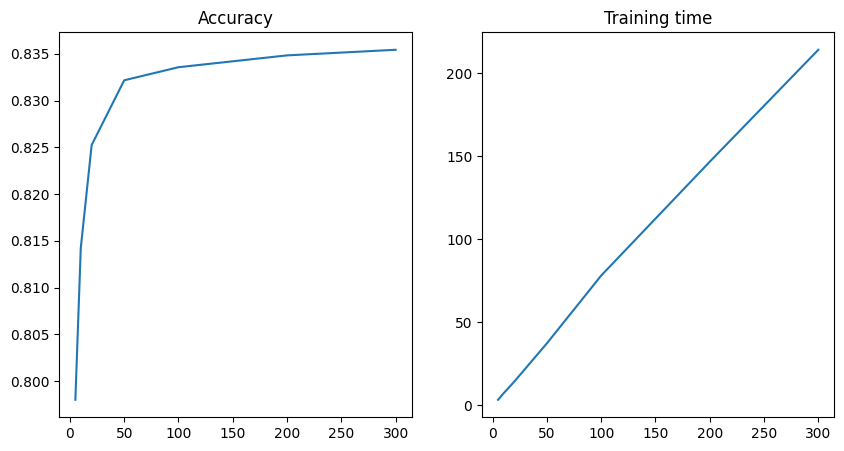

In [69]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(estims,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(estims,tim)
ax2.set_title('Training time')


Let's try Undersampling

In [70]:
X_train1, y_train1 = RandomUnderSampler().fit_resample(X_train,y_train)
estims = [5,10,20,50,100,200,300]
model = RandomForestClassifier()
acc,tim = [], []
for x in estims:
    model = RandomForestClassifier(n_estimators=x,warm_start=True)
    start = time.perf_counter()
    model.fit(X_train1,y_train1)
    end = time.perf_counter()
    y_pred = model.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_estimators: {x}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_estimators: 5, time_taken: 0.7891319999471307s, accuracy: 0.7753932284724073
n_estimators: 10, time_taken: 1.5796254000160843s, accuracy: 0.7933884297520661
n_estimators: 20, time_taken: 2.9931307998485863s, accuracy: 0.807584644094908
n_estimators: 50, time_taken: 7.484269800130278s, accuracy: 0.8115835777126099
n_estimators: 100, time_taken: 14.842837600037456s, accuracy: 0.8131831511596908
n_estimators: 200, time_taken: 29.737965600099415s, accuracy: 0.8146494268195148
n_estimators: 300, time_taken: 43.778003100072965s, accuracy: 0.8147827246067715


Pick best model

In [71]:
model1 = RandomForestClassifier(n_estimators=estims[np.argmax(acc)],warm_start=True)
start = time.perf_counter()
model1.fit(X_train1,y_train1)
end = time.perf_counter()
y_pred = model1.predict(X_val)
_acc = accuracy_score(y_val,y_pred)
print(f'n_estimators: {estims[np.argmax(acc)]}, time_taken: {end-start}s, accuracy: {_acc}')

n_estimators: 300, time_taken: 43.83311500004493s, accuracy: 0.8147827246067715


In [72]:
model.feature_importances_

array([0.00083625, 0.01142319, 0.00864161, 0.01605541, 0.00106835,
       0.00212845, 0.02716236, 0.01429053, 0.01425436, 0.01412137,
       0.03201172, 0.00557477, 0.00041447, 0.00375688, 0.0151726 ,
       0.00713396, 0.01081541, 0.0179683 , 0.00195375, 0.00871809,
       0.03472788, 0.06699692, 0.078937  , 0.0016319 , 0.0016132 ,
       0.00988848, 0.04520222, 0.11938536, 0.13324032, 0.00164365,
       0.01586653, 0.01433609, 0.01670028, 0.0008347 , 0.00858209,
       0.01674042, 0.00103312, 0.00219882, 0.01398026, 0.00039607,
       0.00403841, 0.01680945, 0.01092816, 0.01876395, 0.00192713,
       0.06282569, 0.00162459, 0.00175526, 0.08230762, 0.00158258])

In [73]:
y_pred = model.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'RandomForest_undersampling', 'metrics': x, 'training_time(s)': tim[-1]})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8049132947976878, 'recal...",0.980486
1,Decision_tree_oversampling,"{'0': {'precision': 0.8125783535311325, 'recal...",3.405618
2,Decision_tree_undersampling,"{'0': {'precision': 0.8152288546720101, 'recal...",0.765867
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9437790271327304, 'recal...",76.878531
4,RandomForest_oversampling,"{'0': {'precision': 0.9532803180914513, 'recal...",214.047047
5,RandomForest_undersampling,"{'0': {'precision': 0.9725991649269311, 'recal...",43.778003


Text(0.5, 1.0, 'Training time')

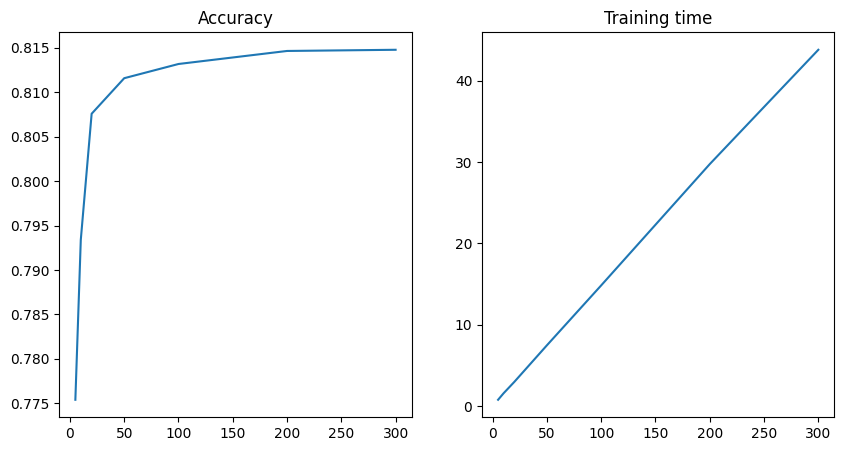

In [74]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(estims,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(estims,tim)
ax2.set_title('Training time')


### Naive Bayes

In [75]:
from sklearn.naive_bayes import GaussianNB

In [76]:
%%time
model_nb = GaussianNB()
start = time.perf_counter()
model_nb.fit(X_train, y_train)
end = time.perf_counter()

CPU times: total: 156 ms
Wall time: 184 ms


In [77]:
y_pred = model_nb.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[ 9667,   638],
        [ 1001,  3698]],

       [[10821,  1222],
        [ 1635,  1326]],

       [[ 5905,  1755],
        [  979,  6365]]], dtype=int64)

In [78]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7004971779922178, 0.7590642495334577)

In [79]:
print('NAIVE BAYES - No preprocessing')
x = classification_report(y_val, y_pred, labels = sorted(list(set(y_enc))), digits=4, output_dict=True)
models.append({'model':'Naive_Bayes_no_preprocessing', 'metrics': x, 'training_time(s)':(end-start)})
pd.DataFrame(models)

NAIVE BAYES - No preprocessing


,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8049132947976878, 'recal...",0.980486
1,Decision_tree_oversampling,"{'0': {'precision': 0.8125783535311325, 'recal...",3.405618
2,Decision_tree_undersampling,"{'0': {'precision': 0.8152288546720101, 'recal...",0.765867
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9437790271327304, 'recal...",76.878531
4,RandomForest_oversampling,"{'0': {'precision': 0.9532803180914513, 'recal...",214.047047
5,RandomForest_undersampling,"{'0': {'precision': 0.9725991649269311, 'recal...",43.778003
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.852859778597786, 'recall...",0.183097


Let's try oversampling 

In [80]:
X_train1, y_train1 = SMOTE().fit_resample(X_train, y_train)

In [81]:
%%time
model_nb = GaussianNB()
start = time.perf_counter()
model_nb.fit(X_train1,y_train1)
end = time.perf_counter()

CPU times: total: 250 ms
Wall time: 140 ms


In [82]:
y_pred = model_nb.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[ 9616,   689],
        [  983,  3716]],

       [[10393,  1650],
        [ 1215,  1746]],

       [[ 6456,  1204],
        [ 1345,  5999]]], dtype=int64)

In [83]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7324431688521561, 0.7638629698747)

In [84]:
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'Naive_Bayes_oversampling', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8049132947976878, 'recal...",0.980486
1,Decision_tree_oversampling,"{'0': {'precision': 0.8125783535311325, 'recal...",3.405618
2,Decision_tree_undersampling,"{'0': {'precision': 0.8152288546720101, 'recal...",0.765867
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9437790271327304, 'recal...",76.878531
4,RandomForest_oversampling,"{'0': {'precision': 0.9532803180914513, 'recal...",214.047047
5,RandomForest_undersampling,"{'0': {'precision': 0.9725991649269311, 'recal...",43.778003
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.852859778597786, 'recall...",0.183097
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8435868331441544, 'recal...",0.139830


Let's try undersampling

In [85]:
X_train1, y_train1 = RandomUnderSampler().fit_resample(X_train, y_train)

In [86]:
%%time
model_nb = GaussianNB()
start = time.perf_counter()
model_nb.fit(X_train1,y_train1)
end = time.perf_counter()

CPU times: total: 0 ns
Wall time: 49.5 ms


In [87]:
y_pred = model_nb.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[ 9667,   638],
        [ 1004,  3695]],

       [[10749,  1294],
        [ 1546,  1415]],

       [[ 6015,  1645],
        [ 1027,  6317]]], dtype=int64)

In [88]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.708124855197024, 0.7615969074913357)

In [89]:
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'Naive_Bayes_undersampling', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8049132947976878, 'recal...",0.980486
1,Decision_tree_oversampling,"{'0': {'precision': 0.8125783535311325, 'recal...",3.405618
2,Decision_tree_undersampling,"{'0': {'precision': 0.8152288546720101, 'recal...",0.765867
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9437790271327304, 'recal...",76.878531
4,RandomForest_oversampling,"{'0': {'precision': 0.9532803180914513, 'recal...",214.047047
5,RandomForest_undersampling,"{'0': {'precision': 0.9725991649269311, 'recal...",43.778003
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.852859778597786, 'recall...",0.183097
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8435868331441544, 'recal...",0.139830
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8527579044541888, 'recal...",0.049715


### K Nearest Neighbors

In [90]:
from sklearn.neighbors import KNeighborsClassifier

In [91]:
nbors = [3,5,10,15,20,25,50,100,200,400,800]
tim, acc = [], []
model_knn = KNeighborsClassifier()

for n in nbors:
    model_knn = KNeighborsClassifier(n_neighbors=n)
    start = time.perf_counter()
    model_knn.fit(X_train,y_train)
    end = time.perf_counter()
    y_pred = model_knn.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_neighbors: {n}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_neighbors: 3, time_taken: 0.014110400108620524s, accuracy: 0.7342042122100774
n_neighbors: 5, time_taken: 0.010513999965041876s, accuracy: 0.7457344708077845
n_neighbors: 10, time_taken: 0.01021890016272664s, accuracy: 0.753998933617702
n_neighbors: 15, time_taken: 0.0096925999969244s, accuracy: 0.753998933617702
n_neighbors: 20, time_taken: 0.00996820000000298s, accuracy: 0.7530658491069048
n_neighbors: 25, time_taken: 0.01020489982329309s, accuracy: 0.751266328978939
n_neighbors: 50, time_taken: 0.010343899950385094s, accuracy: 0.7434684084244202
n_neighbors: 100, time_taken: 0.009793199831619859s, accuracy: 0.7292055451879499
n_neighbors: 200, time_taken: 0.00787029997445643s, accuracy: 0.7113436416955479
n_neighbors: 400, time_taken: 0.011176799889653921s, accuracy: 0.6866169021594242
n_neighbors: 800, time_taken: 0.010877199936658144s, accuracy: 0.6582244734737404


Pick best model

In [92]:
model1 = KNeighborsClassifier(n_neighbors=nbors[np.argmax(acc)])
start = time.perf_counter()
model1.fit(X_train,y_train)
end = time.perf_counter()
y_pred = model1.predict(X_val)
_acc = accuracy_score(y_val,y_pred)
print(f'n_estimators: {nbors[np.argmax(acc)]}, time_taken: {end-start}s, accuracy: {_acc}')
model1.get_params

n_estimators: 10, time_taken: 0.013366300147026777s, accuracy: 0.753998933617702


<bound method BaseEstimator.get_params of KNeighborsClassifier(n_neighbors=10)>

In [93]:
y_pred = model1.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'KNN_no_preprocessing', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8049132947976878, 'recal...",0.980486
1,Decision_tree_oversampling,"{'0': {'precision': 0.8125783535311325, 'recal...",3.405618
2,Decision_tree_undersampling,"{'0': {'precision': 0.8152288546720101, 'recal...",0.765867
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9437790271327304, 'recal...",76.878531
4,RandomForest_oversampling,"{'0': {'precision': 0.9532803180914513, 'recal...",214.047047
5,RandomForest_undersampling,"{'0': {'precision': 0.9725991649269311, 'recal...",43.778003
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.852859778597786, 'recall...",0.183097
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8435868331441544, 'recal...",0.139830
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8527579044541888, 'recal...",0.049715
9,KNN_no_preprocessing,"{'0': {'precision': 0.8735545500251383, 'recal...",0.013366


Text(0.5, 1.0, 'Training time')

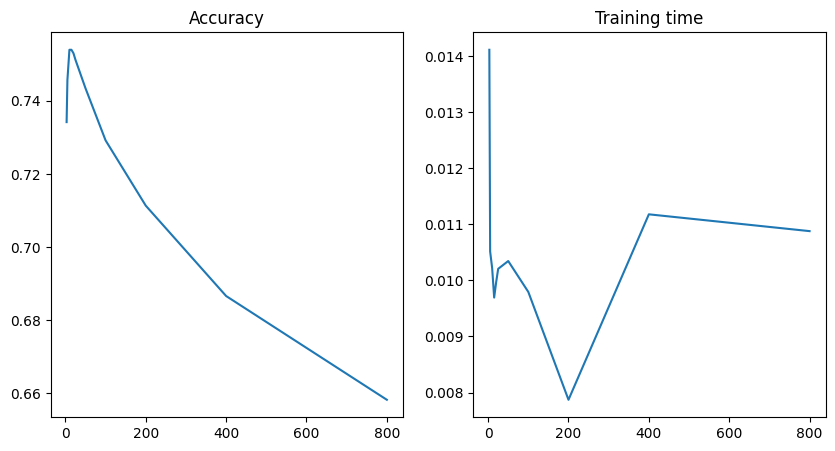

In [94]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(nbors,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(nbors,tim)
ax2.set_title('Training time')

Let's try oversampling

In [95]:
X_train1, y_train1 = SMOTE().fit_resample(X_train,y_train)

In [96]:
nbors = [3,5,10,15,20,25,50,100,200,400,800]
tim, acc = [], []
model_knn = KNeighborsClassifier()

for n in nbors:
    model_knn = KNeighborsClassifier(n_neighbors=n)
    start = time.perf_counter()
    model_knn.fit(X_train1,y_train1)
    end = time.perf_counter()
    y_pred = model_knn.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_neighbors: {n}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_neighbors: 3, time_taken: 0.023888800060376525s, accuracy: 0.6998133830978406
n_neighbors: 5, time_taken: 0.012594599975273013s, accuracy: 0.697880565182618
n_neighbors: 10, time_taken: 0.0130088001023978s, accuracy: 0.6960143961610237
n_neighbors: 15, time_taken: 0.012729099951684475s, accuracy: 0.7042788589709411
n_neighbors: 20, time_taken: 0.013428299920633435s, accuracy: 0.7024126899493468
n_neighbors: 25, time_taken: 0.013093400048092008s, accuracy: 0.7042788589709411
n_neighbors: 50, time_taken: 0.012880700174719095s, accuracy: 0.7004798720341242
n_neighbors: 100, time_taken: 0.014684399822726846s, accuracy: 0.6900159957344708
n_neighbors: 200, time_taken: 0.013776400126516819s, accuracy: 0.679485470541189
n_neighbors: 400, time_taken: 0.014469500165432692s, accuracy: 0.666355638496401
n_neighbors: 800, time_taken: 0.01564290001988411s, accuracy: 0.6429618768328446


Pick best model

In [97]:
model1 = KNeighborsClassifier(n_neighbors=nbors[np.argmax(acc)])
start = time.perf_counter()
model1.fit(X_train1,y_train1)
end = time.perf_counter()
y_pred = model1.predict(X_val)
_acc = accuracy_score(y_val,y_pred)
print(f'n_estimators: {nbors[np.argmax(acc)]}, time_taken: {end-start}s, accuracy: {_acc}')
model1.get_params

n_estimators: 15, time_taken: 0.016962200170382857s, accuracy: 0.7042788589709411


<bound method BaseEstimator.get_params of KNeighborsClassifier(n_neighbors=15)>

In [98]:
y_pred = model1.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'KNN_oversampling', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8049132947976878, 'recal...",0.980486
1,Decision_tree_oversampling,"{'0': {'precision': 0.8125783535311325, 'recal...",3.405618
2,Decision_tree_undersampling,"{'0': {'precision': 0.8152288546720101, 'recal...",0.765867
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9437790271327304, 'recal...",76.878531
4,RandomForest_oversampling,"{'0': {'precision': 0.9532803180914513, 'recal...",214.047047
5,RandomForest_undersampling,"{'0': {'precision': 0.9725991649269311, 'recal...",43.778003
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.852859778597786, 'recall...",0.183097
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8435868331441544, 'recal...",0.139830
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8527579044541888, 'recal...",0.049715
9,KNN_no_preprocessing,"{'0': {'precision': 0.8735545500251383, 'recal...",0.013366


Text(0.5, 1.0, 'Training time')

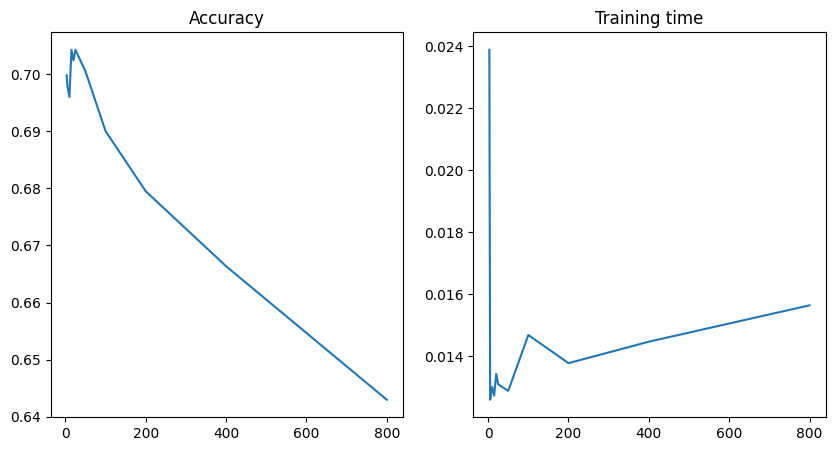

In [99]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(nbors,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(nbors,tim)
ax2.set_title('Training time')

Let's try undersampling

In [100]:
X_train1, y_train1 = RandomUnderSampler().fit_resample(X_train,y_train)

In [101]:
nbors = [3,5,10,15,20,25,50,100,200,400,800]
tim, acc = [], []
model_knn = KNeighborsClassifier()

for n in nbors:
    model_knn = KNeighborsClassifier(n_neighbors=n)
    start = time.perf_counter()
    model_knn.fit(X_train1,y_train1)
    end = time.perf_counter()
    y_pred = model_knn.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_neighbors: {n}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_neighbors: 3, time_taken: 0.011173599865287542s, accuracy: 0.6932817915222608
n_neighbors: 5, time_taken: 0.0038469000719487667s, accuracy: 0.7015462543321781
n_neighbors: 10, time_taken: 0.005143400048837066s, accuracy: 0.7089442815249267
n_neighbors: 15, time_taken: 0.006229099817574024s, accuracy: 0.7101439616102373
n_neighbors: 20, time_taken: 0.005917200120165944s, accuracy: 0.7066115702479339
n_neighbors: 25, time_taken: 0.005157299805432558s, accuracy: 0.7064116235670488
n_neighbors: 50, time_taken: 0.005172699922695756s, accuracy: 0.6948813649693415
n_neighbors: 100, time_taken: 0.004986400017514825s, accuracy: 0.6789522793921621
n_neighbors: 200, time_taken: 0.005647199926897883s, accuracy: 0.6628232471340976
n_neighbors: 400, time_taken: 0.005309300031512976s, accuracy: 0.6383631031724873
n_neighbors: 800, time_taken: 0.005674399901181459s, accuracy: 0.6088376432951214


Pick best model

In [102]:
model1 = KNeighborsClassifier(n_neighbors=nbors[np.argmax(acc)])
start = time.perf_counter()
model1.fit(X_train1,y_train1)
end = time.perf_counter()
y_pred = model1.predict(X_val)
_acc = accuracy_score(y_val,y_pred)
print(f'n_estimators: {nbors[np.argmax(acc)]}, time_taken: {end-start}s, accuracy: {_acc}')
model1.get_params

n_estimators: 15, time_taken: 0.007978500099852681s, accuracy: 0.7101439616102373


<bound method BaseEstimator.get_params of KNeighborsClassifier(n_neighbors=15)>

In [103]:
y_pred = model1.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'KNN_undersampling', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8049132947976878, 'recal...",0.980486
1,Decision_tree_oversampling,"{'0': {'precision': 0.8125783535311325, 'recal...",3.405618
2,Decision_tree_undersampling,"{'0': {'precision': 0.8152288546720101, 'recal...",0.765867
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9437790271327304, 'recal...",76.878531
4,RandomForest_oversampling,"{'0': {'precision': 0.9532803180914513, 'recal...",214.047047
5,RandomForest_undersampling,"{'0': {'precision': 0.9725991649269311, 'recal...",43.778003
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.852859778597786, 'recall...",0.183097
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8435868331441544, 'recal...",0.139830
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8527579044541888, 'recal...",0.049715
9,KNN_no_preprocessing,"{'0': {'precision': 0.8735545500251383, 'recal...",0.013366


Text(0.5, 1.0, 'Training time')

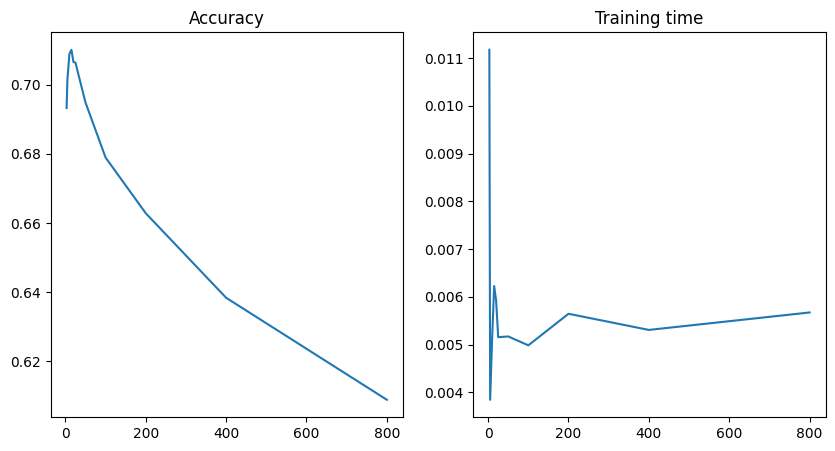

In [104]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(nbors,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(nbors,tim)
ax2.set_title('Training time')

### LightGBM

In [105]:
from lightgbm import LGBMClassifier

In [106]:
%%time
model = LGBMClassifier()
start = time.perf_counter()
model.fit(X_train,y_train)
end = time.perf_counter()
end-start

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1928
[LightGBM] [Info] Number of data points in the train set: 60014, number of used features: 50
[LightGBM] [Info] Start training from score -1.151719
[LightGBM] [Info] Start training from score -1.627750
[LightGBM] [Info] Start training from score -0.718391
CPU times: total: 13 s
Wall time: 2.92 s


2.8818260999396443

In [107]:
y_pred = model.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[10067,   238],
        [  798,  3901]],

       [[11037,  1006],
        [ 1072,  1889]],

       [[ 6478,  1182],
        [  556,  6788]]], dtype=int64)

In [108]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7974762403075025, 0.8383097840575846)

In [109]:
tim, acc = [], []
model_lg = LGBMClassifier()

for n in estims:
    model_lg = LGBMClassifier(n_estimators=n)
    start = time.perf_counter()
    model_lg.fit(X_train,y_train)
    end = time.perf_counter()
    y_pred = model_lg.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_estims: {n}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1928
[LightGBM] [Info] Number of data points in the train set: 60014, number of used features: 50
[LightGBM] [Info] Start training from score -1.151719
[LightGBM] [Info] Start training from score -1.627750
[LightGBM] [Info] Start training from score -0.718391
n_estims: 5, time_taken: 0.31149150012061s, accuracy: 0.8127832577979206
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1928
[LightGBM] [Info] Number of data points in the train set: 60014, number of used features: 50
[LightGBM] [Info] Start training from score -1.151719
[Ligh

In [110]:
n = estims[np.argmax(acc)]
model_lgbm = LGBMClassifier(n_estimators=n)
model_lgbm.fit(X_train,y_train)
y_pred = model_lgbm.predict(X_val)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1928
[LightGBM] [Info] Number of data points in the train set: 60014, number of used features: 50
[LightGBM] [Info] Start training from score -1.151719
[LightGBM] [Info] Start training from score -1.627750
[LightGBM] [Info] Start training from score -0.718391


In [111]:
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'LightGBM_no_preprocessing', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8049132947976878, 'recal...",0.980486
1,Decision_tree_oversampling,"{'0': {'precision': 0.8125783535311325, 'recal...",3.405618
2,Decision_tree_undersampling,"{'0': {'precision': 0.8152288546720101, 'recal...",0.765867
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9437790271327304, 'recal...",76.878531
4,RandomForest_oversampling,"{'0': {'precision': 0.9532803180914513, 'recal...",214.047047
5,RandomForest_undersampling,"{'0': {'precision': 0.9725991649269311, 'recal...",43.778003
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.852859778597786, 'recall...",0.183097
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8435868331441544, 'recal...",0.139830
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8527579044541888, 'recal...",0.049715
9,KNN_no_preprocessing,"{'0': {'precision': 0.8735545500251383, 'recal...",0.013366


Try SMOTE

In [112]:
X_train1,y_train1 = SMOTE().fit_resample(X_train,y_train)

In [113]:
%%time
model = LGBMClassifier()
start = time.perf_counter()
model.fit(X_train1,y_train1)
end = time.perf_counter()
end-start

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11692
[LightGBM] [Info] Number of data points in the train set: 87777, number of used features: 50
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
CPU times: total: 23 s
Wall time: 4.45 s


4.452771199867129

In [114]:
y_pred = model.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[10073,   232],
        [  787,  3912]],

       [[10996,  1047],
        [ 1010,  1951]],

       [[ 6541,  1119],
        [  601,  6743]]], dtype=int64)

In [115]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.8031936885151945, 0.8401759530791789)

In [116]:
tim, acc = [], []
model_lg = LGBMClassifier()

for n in estims:
    model_lg = LGBMClassifier(n_estimators=n)
    start = time.perf_counter()
    model_lg.fit(X_train1,y_train1)
    end = time.perf_counter()
    y_pred = model_lg.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_estims: {n}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11692
[LightGBM] [Info] Number of data points in the train set: 87777, number of used features: 50
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
n_estims: 5, time_taken: 0.5719406998250633s, accuracy: 0.8196480938416423
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11692
[LightGBM] [Info] Number of data points in the train set: 87777, number of used features: 50
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
n_estims: 10, time_ta

In [117]:
n = estims[np.argmax(acc)]
model_lgbm = LGBMClassifier(n_estimators=n)
model_lgbm.fit(X_train1,y_train1)
y_pred = model_lgbm.predict(X_val)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11692
[LightGBM] [Info] Number of data points in the train set: 87777, number of used features: 50
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


In [118]:
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'LightGBM_oversampling', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8049132947976878, 'recal...",0.980486
1,Decision_tree_oversampling,"{'0': {'precision': 0.8125783535311325, 'recal...",3.405618
2,Decision_tree_undersampling,"{'0': {'precision': 0.8152288546720101, 'recal...",0.765867
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9437790271327304, 'recal...",76.878531
4,RandomForest_oversampling,"{'0': {'precision': 0.9532803180914513, 'recal...",214.047047
5,RandomForest_undersampling,"{'0': {'precision': 0.9725991649269311, 'recal...",43.778003
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.852859778597786, 'recall...",0.183097
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8435868331441544, 'recal...",0.139830
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8527579044541888, 'recal...",0.049715
9,KNN_no_preprocessing,"{'0': {'precision': 0.8735545500251383, 'recal...",0.013366


Try Undersampling

In [119]:
X_train1,y_train1 = RandomUnderSampler().fit_resample(X_train,y_train)

In [120]:
%%time
model = LGBMClassifier()
start = time.perf_counter()
model.fit(X_train1,y_train1)
end = time.perf_counter()
end-start

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1892
[LightGBM] [Info] Number of data points in the train set: 35355, number of used features: 50
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
CPU times: total: 10.6 s
Wall time: 2.46 s


2.457265199860558

In [121]:
y_pred = model.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[10156,   149],
        [  904,  3795]],

       [[10277,  1766],
        [  616,  2345]],

       [[ 6923,   737],
        [ 1132,  6212]]], dtype=int64)

In [122]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.8151471278846705, 0.823247134097574)

In [123]:
tim, acc = [], []
model_lg = LGBMClassifier()

for n in estims:
    model_lg = LGBMClassifier(n_estimators=n)
    start = time.perf_counter()
    model_lg.fit(X_train1,y_train1)
    end = time.perf_counter()
    y_pred = model_lg.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_estims: {n}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1892
[LightGBM] [Info] Number of data points in the train set: 35355, number of used features: 50
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
n_estims: 5, time_taken: 0.34236719994805753s, accuracy: 0.8103838976272993
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1892
[LightGBM] [Info] Number of data points in the train set: 35355, number of used features: 50
[LightGBM] [Info] Start training from score -1.098612
[L

In [124]:
n = estims[np.argmax(acc)]
model_lgbm = LGBMClassifier(n_estimators=n)
model_lgbm.fit(X_train1,y_train1)
y_pred = model_lgbm.predict(X_val)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1892
[LightGBM] [Info] Number of data points in the train set: 35355, number of used features: 50
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


In [125]:
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'LightGBM_undersampling', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8049132947976878, 'recal...",0.980486
1,Decision_tree_oversampling,"{'0': {'precision': 0.8125783535311325, 'recal...",3.405618
2,Decision_tree_undersampling,"{'0': {'precision': 0.8152288546720101, 'recal...",0.765867
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9437790271327304, 'recal...",76.878531
4,RandomForest_oversampling,"{'0': {'precision': 0.9532803180914513, 'recal...",214.047047
5,RandomForest_undersampling,"{'0': {'precision': 0.9725991649269311, 'recal...",43.778003
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.852859778597786, 'recall...",0.183097
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8435868331441544, 'recal...",0.139830
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8527579044541888, 'recal...",0.049715
9,KNN_no_preprocessing,"{'0': {'precision': 0.8735545500251383, 'recal...",0.013366


### XGBoost

In [126]:
from xgboost import XGBClassifier

from xgboost import plot_importance

In [127]:
%%time
model_xgb = XGBClassifier(booster='gbtree')
start = time.perf_counter()
model_xgb.fit(X_train,y_train)
end = time.perf_counter()
print(f'Training time: {end-start}s')

Training time: 2.037636199966073s
CPU times: total: 9.73 s
Wall time: 2.04 s


In [128]:
y_pred = model_xgb.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))))
print(x)

              precision    recall  f1-score   support

           0     0.9375    0.8361    0.8839      4699
           1     0.6553    0.6440    0.6496      2961
           2     0.8556    0.9208    0.8870      7344

    accuracy                         0.8396     15004
   macro avg     0.8161    0.8003    0.8068     15004
weighted avg     0.8417    0.8396    0.8392     15004



Try SMOTE

In [129]:
X_train1, y_train1 = SMOTE().fit_resample(X_train,y_train)

In [130]:
%%time
model_xgb = XGBClassifier(booster='gbtree')
start = time.perf_counter()
model_xgb.fit(X_train1,y_train1)
end = time.perf_counter()
print(f'Training time: {end-start}s')

Training time: 3.4850534999277443s
CPU times: total: 18.4 s
Wall time: 3.49 s


In [131]:
y_pred = model_xgb.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))))
print(x)

              precision    recall  f1-score   support

           0     0.9399    0.8353    0.8845      4699
           1     0.6550    0.6545    0.6547      2961
           2     0.8573    0.9186    0.8869      7344

    accuracy                         0.8404     15004
   macro avg     0.8174    0.8028    0.8087     15004
weighted avg     0.8432    0.8404    0.8403     15004



Try undersampling

In [132]:
X_train1, y_train1 = RandomUnderSampler().fit_resample(X_train,y_train)

In [133]:
%%time
model_xgb = XGBClassifier(booster='gbtree')
start = time.perf_counter()
model_xgb.fit(X_train1,y_train1)
end = time.perf_counter()
print(f'Training time: {end-start}s')

Training time: 1.2278279999736696s
CPU times: total: 5.91 s
Wall time: 1.23 s


In [134]:
y_pred = model_xgb.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))))
print(x)

              precision    recall  f1-score   support

           0     0.9548    0.8095    0.8762      4699
           1     0.5690    0.7896    0.6614      2961
           2     0.8938    0.8411    0.8666      7344

    accuracy                         0.8210     15004
   macro avg     0.8059    0.8134    0.8014     15004
weighted avg     0.8488    0.8210    0.8291     15004



## Results

In [135]:
df_results = pd.DataFrame(models)

In [136]:
df_results['precision'] = df_results['metrics'].apply(lambda x: {0: round(x['0']['precision'],3), 1: round(x['1']['precision'],3), 2: round(x['2']['precision'],3)})
df_results['recall'] = df_results['metrics'].apply(lambda x: {0: round(x['0']['recall'],3), 1: round(x['1']['recall'],3), 2: round(x['2']['recall'],3)})
df_results['f1-score'] = df_results['metrics'].apply(lambda x: {0: round(x['0']['f1-score'],3), 1: round(x['1']['f1-score'],3), 2: round(x['2']['f1-score'],3)})
df_results['macro_avg'] = df_results['metrics'].apply(lambda x: {k: round(x['macro avg'][k],3) for k in x['macro avg'].keys()})
df_results['weighted_avg'] = df_results['metrics'].apply(lambda x: {k: round(x['weighted avg'][k],3) for k in x['weighted avg'].keys()})
df_results['accuracy'] = df_results['metrics'].apply(lambda x: round(x['accuracy'],3))
df_results['time (s)'] = df_results['training_time(s)']
df_results.drop(columns=['metrics','training_time(s)'],inplace=True)

In [137]:
df_results.to_csv('data/benchmarking_outliers_handled.csv',index=False)
df_results

,model,precision,recall,f1-score,macro_avg,weighted_avg,accuracy,time (s)
0,Decision_tree_no_preprocessing,"{0: 0.805, 1: 0.503, 2: 0.837}","{0: 0.83, 1: 0.511, 2: 0.815}","{0: 0.817, 1: 0.507, 2: 0.826}","{'precision': 0.715, 'recall': 0.719, 'f1-scor...","{'precision': 0.761, 'recall': 0.76, 'f1-score...",0.760,0.980486
1,Decision_tree_oversampling,"{0: 0.813, 1: 0.509, 2: 0.839}","{0: 0.828, 1: 0.535, 2: 0.812}","{0: 0.82, 1: 0.521, 2: 0.826}","{'precision': 0.72, 'recall': 0.725, 'f1-score...","{'precision': 0.766, 'recall': 0.762, 'f1-scor...",0.762,3.405618
2,Decision_tree_undersampling,"{0: 0.815, 1: 0.462, 2: 0.863}","{0: 0.823, 1: 0.642, 2: 0.722}","{0: 0.819, 1: 0.537, 2: 0.786}","{'precision': 0.713, 'recall': 0.729, 'f1-scor...","{'precision': 0.769, 'recall': 0.738, 'f1-scor...",0.738,0.765867
3,RandomForest_no_preprocessing,"{0: 0.944, 1: 0.647, 2: 0.847}","{0: 0.822, 1: 0.627, 2: 0.928}","{0: 0.878, 1: 0.637, 2: 0.885}","{'precision': 0.813, 'recall': 0.792, 'f1-scor...","{'precision': 0.838, 'recall': 0.835, 'f1-scor...",0.835,76.878531
4,RandomForest_oversampling,"{0: 0.953, 1: 0.632, 2: 0.857}","{0: 0.816, 1: 0.67, 2: 0.914}","{0: 0.88, 1: 0.65, 2: 0.884}","{'precision': 0.814, 'recall': 0.8, 'f1-score'...","{'precision': 0.843, 'recall': 0.835, 'f1-scor...",0.835,214.047047
5,RandomForest_undersampling,"{0: 0.973, 1: 0.552, 2: 0.892}","{0: 0.793, 1: 0.802, 2: 0.834}","{0: 0.874, 1: 0.654, 2: 0.862}","{'precision': 0.805, 'recall': 0.81, 'f1-score...","{'precision': 0.85, 'recall': 0.815, 'f1-score...",0.815,43.778003
6,Naive_Bayes_no_preprocessing,"{0: 0.853, 1: 0.52, 2: 0.784}","{0: 0.787, 1: 0.448, 2: 0.867}","{0: 0.819, 1: 0.481, 2: 0.823}","{'precision': 0.719, 'recall': 0.7, 'f1-score'...","{'precision': 0.753, 'recall': 0.759, 'f1-scor...",0.759,0.183097
7,Naive_Bayes_oversampling,"{0: 0.844, 1: 0.514, 2: 0.833}","{0: 0.791, 1: 0.59, 2: 0.817}","{0: 0.816, 1: 0.549, 2: 0.825}","{'precision': 0.73, 'recall': 0.732, 'f1-score...","{'precision': 0.773, 'recall': 0.764, 'f1-scor...",0.764,0.139830
8,Naive_Bayes_undersampling,"{0: 0.853, 1: 0.522, 2: 0.793}","{0: 0.786, 1: 0.478, 2: 0.86}","{0: 0.818, 1: 0.499, 2: 0.825}","{'precision': 0.723, 'recall': 0.708, 'f1-scor...","{'precision': 0.758, 'recall': 0.762, 'f1-scor...",0.762,0.049715
9,KNN_no_preprocessing,"{0: 0.874, 1: 0.525, 2: 0.768}","{0: 0.74, 1: 0.457, 2: 0.883}","{0: 0.801, 1: 0.488, 2: 0.821}","{'precision': 0.722, 'recall': 0.693, 'f1-scor...","{'precision': 0.753, 'recall': 0.754, 'f1-scor...",0.754,0.013366


In [138]:
def get_results(df):

    fields = {'model':df['model'].values, 'precision':[x['precision'] for x in df['macro_avg'].values],
                'recall':[x['recall'] for x in df['macro_avg'].values], 'f1-score':[x['f1-score'] for x in df['macro_avg'].values],
                'accuracy':df['accuracy'].values, 'time (s)': df['time (s)']}
    
    return pd.DataFrame(fields)

In [139]:
res = get_results(df_results)
res

,model,precision,recall,f1-score,accuracy,time (s)
0,Decision_tree_no_preprocessing,0.715,0.719,0.717,0.760,0.980486
1,Decision_tree_oversampling,0.720,0.725,0.722,0.762,3.405618
2,Decision_tree_undersampling,0.713,0.729,0.714,0.738,0.765867
3,RandomForest_no_preprocessing,0.813,0.792,0.800,0.835,76.878531
4,RandomForest_oversampling,0.814,0.800,0.805,0.835,214.047047
5,RandomForest_undersampling,0.805,0.810,0.796,0.815,43.778003
6,Naive_Bayes_no_preprocessing,0.719,0.700,0.708,0.759,0.183097
7,Naive_Bayes_oversampling,0.730,0.732,0.730,0.764,0.139830
8,Naive_Bayes_undersampling,0.723,0.708,0.714,0.762,0.049715
9,KNN_no_preprocessing,0.722,0.693,0.704,0.754,0.013366
